In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: 
Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
cd /content/gdrive/My Drive/Colab Notebooks/AppliedML/vision/torchvision/models/detection

/content/gdrive/My Drive/Colab Notebooks/AppliedML/vision/torchvision/models/detection


## Video Object Segmentation

* Segmenting a particular object instance through the entire video sequence.

* Pixel-level object tracking problem

* Application: Video editing, summarization, etc


#### Technique used


* Recognize a “region of interest” and monitoring its motion across multiple frames

* Object is monitored for spatial and temporal changes through a sequence of frames

* Technique used “Tracking by Segmentation” i.e. image segmentation followed by data association to obtain the full trajectory



#### Challenges
* Rapid movement of objects across frames

* Changing object orientation

* Changing illumination 



#### Methodology

Step 1: Mask-RCNN for instance segmentation

Step 2: Optical flow computation using Lucas-Kanade algorithm for tracking


In [11]:
from collections import OrderedDict

import torch
from torch import nn
import torch.nn.functional as F
# import torchvision
from torchvision import models
from torchvision.ops import misc as misc_nn_ops
from torchvision.ops import MultiScaleRoIAlign

from torchvision.models.utils import load_state_dict_from_url

from faster_rcnn import FasterRCNN
from backbone_utils import resnet_fpn_backbone

from generalized_mask_rcnn import GeneralizedRCNN
from rpn import AnchorGenerator, RPNHead, RegionProposalNetwork
from roi_heads import RoIHeads
from transform import GeneralizedRCNNTransform

from torchvision import transforms


%pylab inline 
import cv2
from IPython.display import clear_output


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [0]:
__all__ = [
    "MaskRCNN", "maskrcnn_resnet50_fpn",
]

### MASK RCNN Architecture

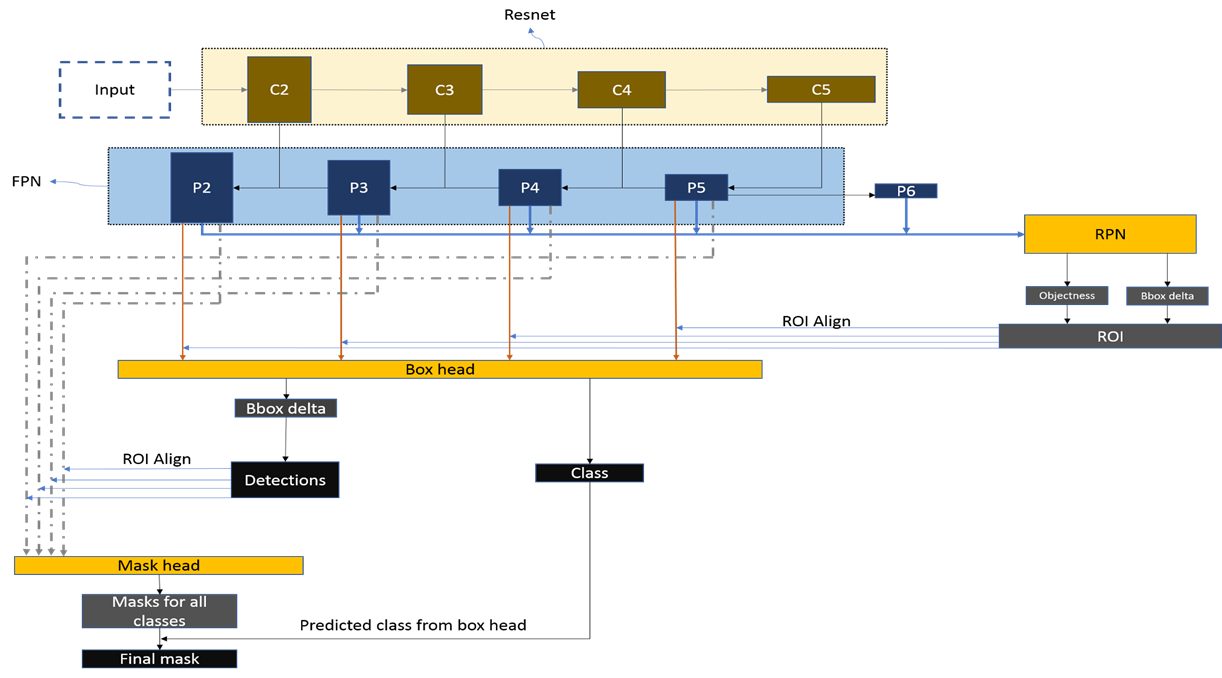

In [12]:
from IPython.display import Image
with open('Mask_RCNN-Architecture.png','rb') as f:
    display(Image(data=f.read(), format='png'))

### Implements Mask R-CNN.
The ***input to the model*** is expected to be a list of tensors, each of shape [C, H, W], one for each image, and should be in 0-1 range. Different images can have different sizes. The behavior of the model changes depending if it is in training or evaluation mode. During training, the model expects both the input tensors, as well as a targets (list of dictionary),containing:
* boxes (FloatTensor[N, 4]): the ground-truth boxes in [x1, y1, x2, y2] format, with values of x between 0 and W and values of y between 0 and H
* labels (Int64Tensor[N]): the class label for each ground-truth box
* masks (UInt8Tensor[N, H, W]): the segmentation binary masks for each instance

The ***model returns a Dict[Tensor]*** during training, containing the classification and regression losses for both the RPN and the R-CNN, and the mask loss. During inference, the model requires only the input tensors, and returns the post-processed predictions as a List[Dict[Tensor]], one for each input image. The fields of the Dict are as follows:
* boxes (FloatTensor[N, 4]): the predicted boxes in [x1, y1, x2, y2] format, with values of x between 0 and W and values of y between 0 and H
* labels (Int64Tensor[N]): the predicted labels for each image
* scores (Tensor[N]): the scores or each prediction
* masks (UInt8Tensor[N, 1, H, W]): the predicted masks for each instance, in 0-1 range. In order to obtain the final segmentation masks, the soft masks can be thresholded, generally with a value of 0.5 (mask >= 0.5)

In [0]:

class MaskRCNN(FasterRCNN):
    def __init__(self, backbone, num_classes=None,
                 # transform parameters
                 min_size=800, max_size=1333,
                 image_mean=None, image_std=None,
                 # RPN parameters
                 rpn_anchor_generator=None, rpn_head=None,
                 rpn_pre_nms_top_n_train=2000, rpn_pre_nms_top_n_test=1000,
                 rpn_post_nms_top_n_train=2000, rpn_post_nms_top_n_test=1000,
                 rpn_nms_thresh=0.7,
                 rpn_fg_iou_thresh=0.7, rpn_bg_iou_thresh=0.3,
                 rpn_batch_size_per_image=256, rpn_positive_fraction=0.5,
                 # Box parameters
                 box_roi_pool=None, box_head=None, box_predictor=None,
                 box_score_thresh=0.05, box_nms_thresh=0.5, box_detections_per_img=100,
                 box_fg_iou_thresh=0.5, box_bg_iou_thresh=0.5,
                 box_batch_size_per_image=512, box_positive_fraction=0.25,
                 bbox_reg_weights=None,
                 # Mask parameters
                 mask_roi_pool=None, mask_head=None, mask_predictor=None):

        assert isinstance(mask_roi_pool, (MultiScaleRoIAlign, type(None)))

        if num_classes is not None:
            if mask_predictor is not None:
                raise ValueError("num_classes should be None when mask_predictor is specified")

        out_channels = backbone.out_channels

        if mask_roi_pool is None:
            mask_roi_pool = MultiScaleRoIAlign(
                featmap_names=['0', '1', '2', '3'],
                output_size=14,
                sampling_ratio=2)

        if mask_head is None:
            mask_layers = (256, 256, 256, 256)
            mask_dilation = 1
            mask_head = MaskRCNNHeads(out_channels, mask_layers, mask_dilation)

        if mask_predictor is None:
            mask_predictor_in_channels = 256  # == mask_layers[-1]
            mask_dim_reduced = 256
            mask_predictor = MaskRCNNPredictor(mask_predictor_in_channels,
                                               mask_dim_reduced, num_classes)

        super(MaskRCNN, self).__init__(
            backbone, num_classes,
            # transform parameters
            min_size, max_size,
            image_mean, image_std,
            # RPN-specific parameters
            rpn_anchor_generator, rpn_head,
            rpn_pre_nms_top_n_train, rpn_pre_nms_top_n_test,
            rpn_post_nms_top_n_train, rpn_post_nms_top_n_test,
            rpn_nms_thresh,
            rpn_fg_iou_thresh, rpn_bg_iou_thresh,
            rpn_batch_size_per_image, rpn_positive_fraction,
            # Box parameters
            box_roi_pool, box_head, box_predictor,
            box_score_thresh, box_nms_thresh, box_detections_per_img,
            box_fg_iou_thresh, box_bg_iou_thresh,
            box_batch_size_per_image, box_positive_fraction,
            bbox_reg_weights)

        self.roi_heads.mask_roi_pool = mask_roi_pool
        self.roi_heads.mask_head = mask_head
        self.roi_heads.mask_predictor = mask_predictor


In [0]:
class MaskRCNNHeads(nn.Sequential):
    def __init__(self, in_channels, layers, dilation):
        d = OrderedDict()
        next_feature = in_channels
        for layer_idx, layer_features in enumerate(layers, 1):
            d["mask_fcn{}".format(layer_idx)] = misc_nn_ops.Conv2d(
                next_feature, layer_features, kernel_size=3,
                stride=1, padding=dilation, dilation=dilation)
            d["relu{}".format(layer_idx)] = nn.ReLU(inplace=True)
            next_feature = layer_features

        super(MaskRCNNHeads, self).__init__(d)
        for name, param in self.named_parameters():
            if "weight" in name:
                nn.init.kaiming_normal_(param, mode="fan_out", nonlinearity="relu")
            # elif "bias" in name:
            #     nn.init.constant_(param, 0)




In [0]:
class MaskRCNNPredictor(nn.Sequential):
    def __init__(self, in_channels, dim_reduced, num_classes):
        super(MaskRCNNPredictor, self).__init__(OrderedDict([
            ("conv5_mask", misc_nn_ops.ConvTranspose2d(in_channels, dim_reduced, 2, 2, 0)),
            ("relu", nn.ReLU(inplace=True)),
            ("mask_fcn_logits", misc_nn_ops.Conv2d(dim_reduced, num_classes, 1, 1, 0)),
        ]))

        for name, param in self.named_parameters():
            if "weight" in name:
                nn.init.kaiming_normal_(param, mode="fan_out", nonlinearity="relu")
            # elif "bias" in name:
            #     nn.init.constant_(param, 0)


model_urls = {
    'maskrcnn_resnet50_fpn_coco':
        'https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth',
}

### Constructs a Mask R-CNN model with a ResNet-50-FPN backbone.
The ***input to the model*** is expected to be a list of tensors, each of shape ``[C, H, W]``, one for each image, and should be in ``0-1`` range. Different images can have different sizes. The behavior of the model changes depending if it is in training or evaluation mode. During training, the model expects both the input tensors, as well as a targets (list of dictionary), containing:
* boxes (``FloatTensor[N, 4]``): the ground-truth boxes in ``[x1, y1, x2, y2]`` format,  with values of ``x`` between ``0`` and ``W`` and values of ``y`` between ``0`` and ``H``
* labels (``Int64Tensor[N]``): the class label for each ground-truth box
* masks (``UInt8Tensor[N, H, W]``): the segmentation binary masks for each instance
    
The ***model returns*** a ``Dict[Tensor]`` during training, containing the classification and regression losses for both the RPN and the R-CNN, and the mask loss. During inference, the model requires only the input tensors, and returns the post-processed
predictions as a ``List[Dict[Tensor]]``, one for each input image. The fields of the ``Dict`` are as follows:
* boxes (``FloatTensor[N, 4]``): the predicted boxes in ``[x1, y1, x2, y2]`` format,  with values of ``x`` between ``0`` and ``W`` and values of ``y`` between ``0`` and ``H``
* labels (``Int64Tensor[N]``): the predicted labels for each image
* scores (``Tensor[N]``): the scores or each prediction
* masks (``UInt8Tensor[N, 1, H, W]``): the predicted masks for each instance, in ``0-1`` range. In order to obtain the final segmentation masks, the soft masks can be thresholded, generally with a value of 0.5 (``mask >= 0.5``)

In [0]:
def maskrcnn_resnet50_fpn(pretrained=False, progress=True,
                          num_classes=91, pretrained_backbone=True, **kwargs):
    if pretrained:
        # no need to download the backbone if pretrained is set
        pretrained_backbone = False
    backbone = resnet_fpn_backbone('resnet50', pretrained_backbone)
    model = MaskRCNN(backbone, num_classes, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['maskrcnn_resnet50_fpn_coco'],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

In [0]:
model = maskrcnn_resnet50_fpn(pretrained=True)
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)


Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


In [0]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [0]:
def get_prediction(frame, threshold):
	  # img = Image.open(img_path)
    pilImg = Image.fromarray(frame)
    img = pilImg
    transform = transforms.Compose([transforms.ToTensor()])
    img = transform(img)
    pred = model([img])
    pred_score = list(pred[0]['scores'].detach().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
   
    masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()

    # print(pred[0]['masks'].shape,masks.shape)
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
    masks = masks[:pred_t+1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    return masks, pred_boxes, pred_class#, np.array(mask_coor, dtype=np.float32)

In [0]:
def random_colour_masks(image):
	  colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
	  r = np.zeros_like(image).astype(np.uint8)
	  # print(r[image==1])
	  g = np.zeros_like(image).astype(np.uint8)
	  b = np.zeros_like(image).astype(np.uint8)
	  r[image == 1], g[image == 1], b[image == 1] = colours[random.randrange(0,10)]
	  coloured_mask = np.stack([r, g, b], axis=2)
	  mask_coor =[[[i[1],i[0]]] for i in np.argwhere(np.rollaxis(coloured_mask, 2, 0)[0]>0) if len(i)>0]  
	  # print(image.shape,r[image==1].shape, g[image == 1].shape, b[image == 1].shape,coloured_mask.shape, coloured_mask_1[:3] )
	  return coloured_mask, mask_coor

In [0]:
def instance_segmentation_api(frame, threshold=0.5, rect_th=1, text_size=0.5, text_th=0.5):
	#masks, boxes, pred_cls, mask_coor = get_prediction(frame, threshold)
	masks, boxes, pred_cls = get_prediction(frame, threshold)
	img = frame
	img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
	# print(pred_cls)
	mask_coors = []
	for i in range(len(masks)):
		rgb_mask, mask_coor = random_colour_masks(masks[i])
		mask_coors = mask_coors + mask_coor
		img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
		cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
		cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)

	plt.figure(figsize=(20,30))
	plt.imshow(img)
	plt.xticks([])
	plt.yticks([])
	plt.show()
  

In [0]:
import random
import cv2 as cv
import numpy as np
from google.colab.patches import cv2_imshow


In [0]:
videopath = 'images/overpass.mp4'

vid = cv2.VideoCapture(videopath)
length = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
width  = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps    = vid.get(cv2.CAP_PROP_FPS)

print(length, width,height,fps)

In [0]:
while(vid.isOpened() and ii < 20 ):
    ret, frame = vid.read()
    # print(frame.shape)
    # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # pilimg = Image.fromarray(frame)
    instance_segmentation_api(frame, threshold=0.5, rect_th=2, text_size=1, text_th=1)
    # object_detection_api(pilimg,model,"out_"+str(ii)+".jpg", rect_th=2, text_th=1, text_size=1)
    # object_detection_api(pilimg,model,ii, threshold=0.9, rect_th=2, text_th=1, text_size=1)
    ii=ii+1

In [0]:
def instance_segmentation(frame, ii, threshold=0.5, rect_th=1, text_size=1, text_th=1):
  masks, boxes, pred_cls = get_prediction(frame, threshold)
  img = frame
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  mask_coors = []
  for i in range(len(masks)):
    rgb_mask, mask_coor = random_colour_masks(masks[i])
    if len(mask_coor)>0:
      mask_coors= mask_coors + mask_coor
      img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
      cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
      cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
  plt.figure(figsize=(20,30))
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()
  plt.savefig("mask_flow/{i}.jpg".format(i=ii))
  print("final coor", mask_coors[:3] )
  return np.array(mask_coors, dtype=np.float32)

Sparse Optical Flow : Lucas Kanade Algorithm



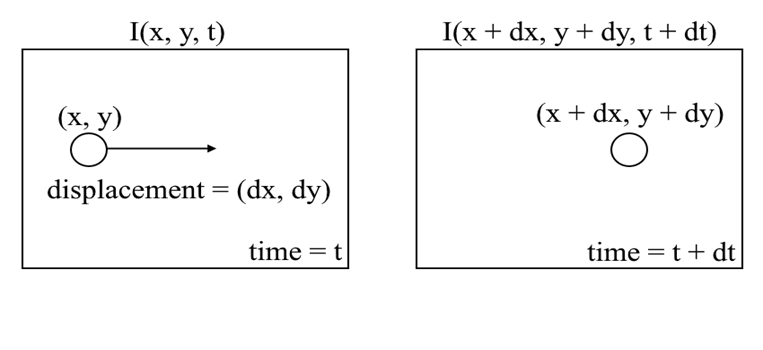

In [13]:
with open('opticalflow.png','rb') as f:
    display(Image(data=f.read(), format='png'))

Lucas Kanade Algorithm
* Lucas-Kanade method takes a 3x3 patch around the point. 
* Find (fx,fy,ft) for these 9 points. 
* The problem reduces to solving 9 equations with two unknown variables which is over-determined. 
* It is solved using least square fit method


In [0]:
cap = cv.VideoCapture(videopath)
threshold = 0.5
feature_params = dict(maxCorners = 300, qualityLevel = 0.2, minDistance = 2, blockSize = 7)
lk_params = dict(winSize = (15,15), maxLevel = 2, criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))
color = (0, 255, 0)
ret, first_frame = cap.read()
mask_coor = instance_segmentation(first_frame, threshold)
print("mask_coor",first_frame.shape, mask_coor[:3], type(np.array(mask_coor)))
prev_gray = cv.cvtColor(first_frame, cv.COLOR_BGR2GRAY)


In [0]:

threshold = 0.5
feature_params = dict(maxCorners = 300, qualityLevel = 0.2, minDistance = 2, blockSize = 7)
lk_params = dict(winSize = (15,15), maxLevel = 2, criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))
color = (0, 255, 0)
ret, first_frame = cap.read()
mask_coor = instance_segmentation(first_frame, 0, threshold)
prev_gray = cv.cvtColor(first_frame, cv.COLOR_BGR2GRAY)
prev = mask_coor
mask = np.zeros_like(first_frame)
ii=1
while(cap.isOpened() and ii<31):
    ret, frame = cap.read()
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    if ii%10 == 0:
      mask_coor = instance_segmentation(frame, ii, threshold)
      prev = mask_coor
    next, status, error = cv.calcOpticalFlowPyrLK(prev_gray, gray, prev, None, **lk_params)
    good_old = prev[status == 1]
    good_new = next[status == 1]
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel()
        c, d = old.ravel()
        mask = cv.line(mask, (a, b), (c, d), color, 2)
        frame = cv.circle(frame, (a, b), 3, color, -1)
    output = cv.add(frame, mask)
    prev_gray = gray.copy()
    prev = good_new.reshape(-1, 1, 2)
    cv2_imshow(output)
    if ii%10 != 0:
      cv2.imwrite("mask_flow/{i}.jpg".format(i=ii), output) 
    if cv.waitKey(10) & 0xFF == ord('q'):
        break
    ii+=1
cap.release()
cv.destroyAllWindows()

### Resource:
1. Video Object Segmentation and Tracking: A Survey RUI YAO,GUOSHENG LIN,
SHIXIONG XIA, JIAQI ZHAO, and YONG ZHOU
2. Mask R-CNN Kaiming He, Georgia Gkioxari, Piotr Dollár, Ross Girshick [link](https://arxiv.org/abs/1703.06870://) [code](https://github.com/pytorch/vision/tree/master/torchvision/models/detection)
3. Lucas Kanade Algorithm [link](https://en.wikipedia.org/wiki/Lucas%E2%80%93Kanade_method); code from open cv

In [0]:
import imageio
import matplotlib.pyplot as plt
from pygifsicle import optimize

n = 30
gif_path = "results.gif"
frames_path = "mask_flow/{i}.jpg"

with imageio.get_writer(gif_path, mode='I') as writer:
    for i in range(1,n):
        writer.append_data(imageio.imread(frames_path.format(i=i)))

# optimize(gif_path)